In [98]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_hist,RSI,MACD_Strategy,RSI_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
13,566.159973,566.200012,566.012695,566.012695,121344,566.023473,565.976895,0.046579,0.034749,0.011830,67.827482,NaN,NaN,NaN,0,NaN,NaN
14,566.130005,566.169983,566.114990,566.169983,48856,566.041319,565.993194,0.048125,0.037522,0.010603,65.972145,1.0,-1.0,0.0,0,-0.000053,0.000000
15,566.109985,566.169983,566.090027,566.130005,34350,566.052667,566.005206,0.047461,0.039567,0.007893,71.161589,1.0,-1.0,0.0,0,-0.000088,0.000000
16,566.286987,566.330017,566.099976,566.099976,85698,566.090953,566.033305,0.057648,0.043267,0.014381,79.437439,1.0,-1.0,0.0,0,0.000224,0.000000
17,566.250000,566.320007,566.229797,566.260010,40226,566.116695,566.054319,0.062375,0.047159,0.015217,73.557376,1.0,-1.0,0.0,0,0.000159,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935,581.919617,581.940002,581.770020,581.820007,65488,581.729670,581.615550,0.114120,0.085610,0.028510,63.741857,1.0,-1.0,0.0,0,0.027836,0.006541
1936,581.940002,581.969910,581.869995,581.919983,97345,581.762028,581.638725,0.123304,0.093149,0.030155,64.202804,1.0,-1.0,0.0,0,0.027872,0.006541
1937,581.945007,582.000000,581.849976,581.940002,82816,581.790179,581.660602,0.129577,0.100434,0.029143,75.128535,1.0,-1.0,0.0,0,0.027881,0.006541
1938,581.859985,581.994995,581.799988,581.950012,56569,581.800918,581.674844,0.126075,0.105562,0.020512,65.155720,1.0,-1.0,0.0,0,0.027731,0.006541


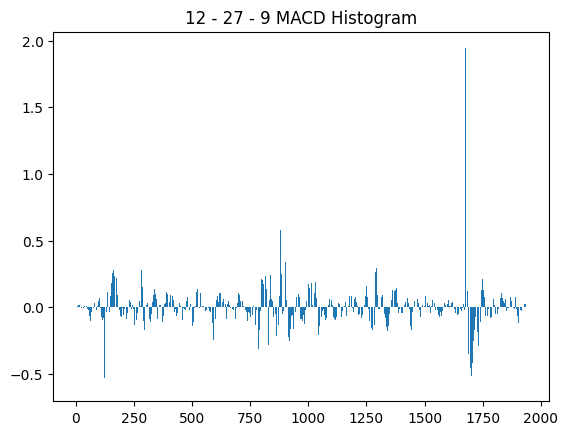

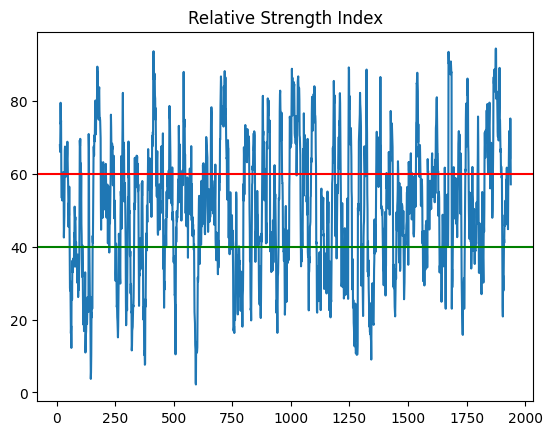

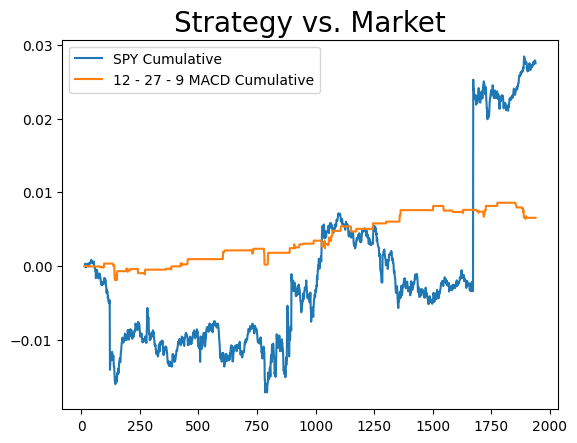

In [99]:
TICKER = 'SPY'
INTERVAL='1m'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

RSI_LENGTH = 14
OVERBOUGHT = 60
OVERSOLD = 40
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# what subsetion of that data are you interested in
LOOKBACK = 10000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MACD_strategy(df):

    df['MACD_Strategy'] = 0
    df['MACD_Strategy'] = np.where(df['MACD_hist'] > 0, 1, -1)
    df['MACD_Strategy'] = df['MACD_Strategy'].shift(1)
    return df

def add_RSI(df, length=RSI_LENGTH):

    price_change = df['Close'].diff()
    
    # separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color='red')
    plt.axhline(OVERSOLD, color='green')
    plt.title('Relative Strength Index')

    return df.dropna()

def add_RSI_strategy(df, overbought=OVERBOUGHT, oversold=OVERSOLD):

    df['RSI_Strategy'] = 0
    df['RSI_Strategy'] = np.where(df['RSI'] > overbought, -1, 
                     np.where(df['RSI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['RSI_Strategy'] = df['RSI_Strategy'].shift(1)
    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['MACD_Strategy'] + df['RSI_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, 
                     np.where(df['Full_Strategy'] == -2, -1, 0))

    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative', f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Cumulative'])
    plt.title('Strategy vs. Market', size='20')

    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_RSI(df)
    df = add_MACD_strategy(df)
    df = add_RSI_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df

df = main()
df

In [100]:
df['Strategy'].value_counts()

Strategy
 0    1796
-1      86
 1      45
Name: count, dtype: int64